In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [21]:
starbucks = pd.read_csv('data/starbucks.csv')
air = pd.read_csv('data/airline_passengers.csv')
price = pd.read_csv('data/price_of_ground_chuck.csv')

## 8.1 Stationarity and differencing
- stationarity : properties do not depend on the time at which the series is observed
    - mean 
    - var
    - cov
- differencing : compute the differences between consecutive observations (to make a non-stationary time series stationary)

### Random walk model
- $y_t = y_{t-1} + \epsilon_t$ (zero mean case)
- widely used for non-stationary data
    - long periods of apparent trends up or down
    - sudden and unpredictable changes in direction
- forecast : equal to the last observation

### Second-order differencing
- sometimes difference the data a second time to obtain a stationary series
- $y_t'' = y_t' - y_{t-1}' = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$

### Seasonal differencing
- $y_t' = y_t - y_{t-m}$
- lag-m difference

### Unit root tests
- one way to determine more objectively whether differencing is required
- KPSS test
    - null hypothesis : data are stationary

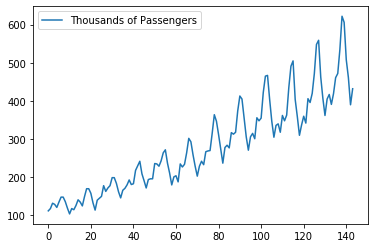

In [5]:
# non-stationary time series
air.plot()
plt.show()

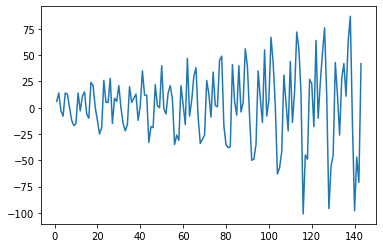

In [6]:
# diff
from statsmodels.tsa.statespace.tools import diff

air['dif1'] = diff(air['Thousands of Passengers'], k_diff=1)

air['dif1'].plot()
plt.show()

In [17]:
# unit test
from statsmodels.tsa.stattools import kpss
# from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

kpss(air['Thousands of Passengers'])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(1.0521750110135097,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## 8.2 Backshift notation
- Backshift operator $B$
- $B y_t = y_{t-1}$

## 8.3 Autoregressive models
- AR(p) : $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$
- For AR(1)
    - when $\phi=0$, $y_t$ is equivalent to a white noise
    - when $\phi=1, c \neq 0$, $y_t$ is equivalent to a random walk with drift
    - when $\phi=1, c=0$, $y_t$ is equivalent to a random walk

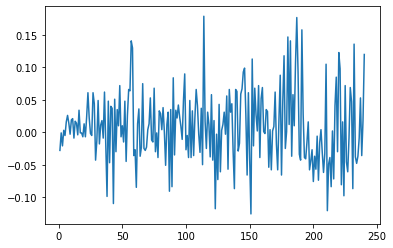

In [41]:
price['dif1'] = diff(price['Price'], k_diff=1)

price['dif1'].plot()

In [48]:
print(price.shape)
train = price[:200]
test = price[200:]

(241, 4)


In [49]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

In [76]:
# model fitting
ar1 = AR(train['dif1'].fillna(train.loc[1,'dif1']))
ar1fit = ar1.fit(maxlag=1, method = 'mle')
ar1fit.summary()

# print(f'Lag: {ar1fit.k_ar}')
# print(f'Coefficients:\n{ar1fit.params}')
# print(f'AIC : {ar1fit.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      d  -                  i                  f
Model:                          AR(1)   Log Likelihood                 305.992
Method:                           mle   S.D. of innovations              0.052
Date:                Fri, 10 Jul 2020   AIC                             -5.868
Time:                        14:05:53   BIC                             -5.818
Sample:                             0   HQIC                            -5.848
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0124      0.004      3.269      0.001       0.005       0.020
L1.dif1       -0.0754      0.071     -1.069      0.285      -0.214       0.063
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -13.2639           +0.0000j           13.2639            0.5000
-----------------------------------------------------------------------------
"""

In [68]:
# forecast
start=len(train)
end=len(train)+len(test)-1
pred = ar1fit.predict(start=start, end=end).rename('AR(1) Predictions')

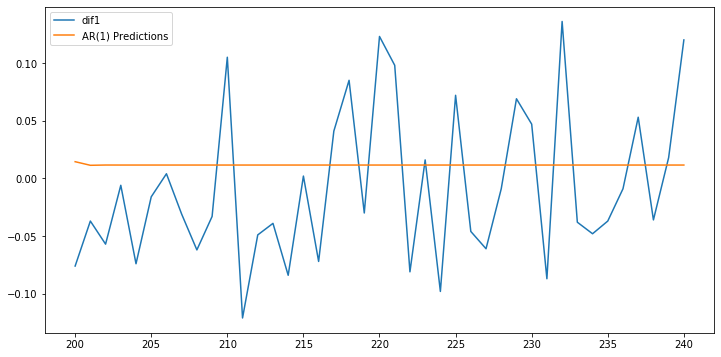

In [69]:
test['dif1'].plot(legend=True)
pred.plot(legend=True,figsize=(12,6));

## 8.4 Moving average models
- MA(q) : $y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$

## 8.5 Non-seasonal ARIMA models
- ARIMA(p,d,q)
    - p : order of the autoregressive part
    - d : degree of first differencing involved
    - q : order of the moving average part
- $y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p}
     + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

In [77]:
# acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

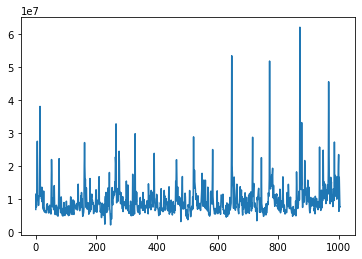

In [89]:
starbucks['Volume'].plot()

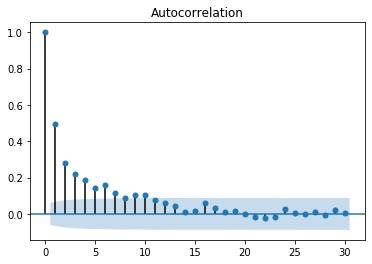

In [91]:
plot_acf(starbucks['Volume'], lags=30)
plt.show()

ACF : exponetially! -> AR

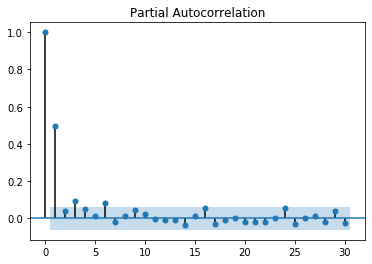

In [92]:
plot_pacf(starbucks['Volume'], lags=30)
plt.show()

PACF : only lag1 is valid!

maybe ARIMA(1,0,0) could be right!!

In [100]:
p = kpss(starbucks['Volume'])[1]

print(f'p-value : {p}')
if p < 0.5 :
    print('Stationary!')
else:
    print('Non-stationary')

p-value : 0.01836489968616624
Stationary!


In [102]:
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults

In [104]:
# Set one month for testing
train = starbucks.loc[:900,'Volume']
test = starbucks.loc[900:, 'Volume']

In [105]:
model = ARIMA(train,order=(1,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Volume   No. Observations:                  901
Model:                     ARMA(1, 0)   Log Likelihood              -15023.462
Method:                       css-mle   S.D. of innovations        4219015.299
Date:                Fri, 10 Jul 2020   AIC                          30052.924
Time:                        16:02:23   BIC                          30067.335
Sample:                             0   HQIC                         30058.429
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.363e+06    2.8e+05     33.488      0.000    8.82e+06    9.91e+06
ar.L1.Volume     0.4978      0.029     17.250      0.000       0.441       0.554
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0087           +0.0000j            2.0087            0.0000
-----------------------------------------------------------------------------
"""

In [107]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(1,0,0) Predictions')

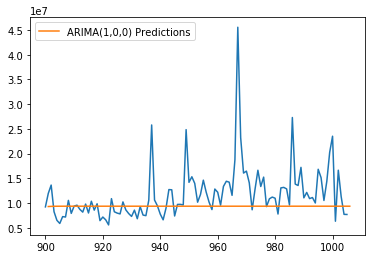

In [109]:
test.plot()
predictions.plot(legend=True)

## 8.7 ARIMA modelling
1. Plot the data and identify any unusual observations.
2. If necessary, transform the data (using a Box-Cox transformation) to stabilise the variance.
3. If the data are non-stationary, take first differences of the data until the data are stationary.
4. Examine the ACF/PACF: Which is an ARIMA model appropriate?
5. Try your chosen model(s), and use the AICc to search for a better model.
6. Check the residuals from your chosen model by plotting the ACF of the residuals, and doing a portmanteau test of the residuals. If they do not look like white noise, try a modified model.
7. Once the residuals look like white noise, calculate forecasts.

## 8.9 Seasonal ARIMA models
- $AIRMA(p,d,q)(P,D,Q)_m$

In [22]:
air.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


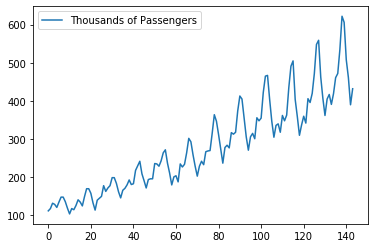

In [4]:
air.plot()

1. box-cox transform for stabilize variance

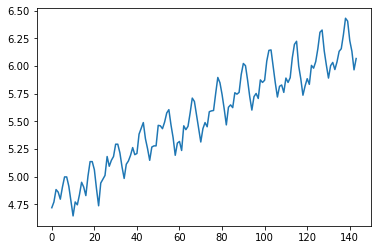

In [7]:
np.log(air['Thousands of Passengers']).plot()

In [23]:
air['log'] = np.log(air['Thousands of Passengers'])

2. difference for trend and seasonal

In [10]:
from statsmodels.tsa.statespace.tools import diff

In [24]:
air['log_dif1_dif12'] = diff(air['log'], k_diff=1, k_seasonal_diff=12)

In [28]:
air.head()

,Month,Thousands of Passengers,log,log_dif1_dif12
0,1949-01,112,4.718499,NaN
1,1949-02,118,4.770685,NaN
2,1949-03,132,4.882802,NaN
3,1949-04,129,4.859812,NaN
4,1949-05,121,4.795791,NaN


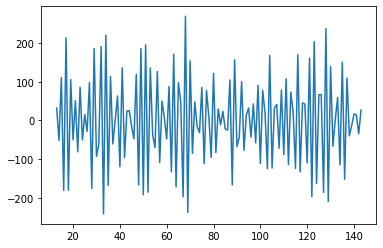

In [26]:
air['log_dif1_dif12'].plot()

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [47]:
def tsaplot(arr):
    gridsize = (2,2)
    fig = plt.figure(figsize=(12,8))
    ax0 = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=1)
    ax1 = plt.subplot2grid(gridsize, (1,0))
    ax2 = plt.subplot2grid(gridsize, (1,1))
    
    ax0.plot(arr)
    plot_acf(arr, ax=ax1, lags=36)
    plot_pacf(arr, ax=ax2, lags=36)
    plt.show()

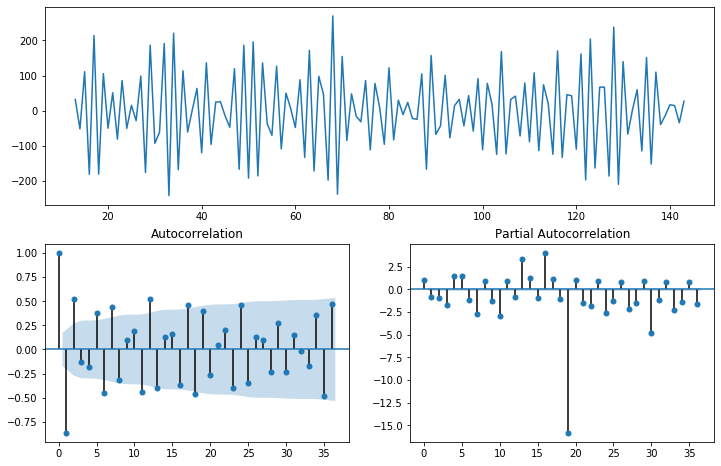

In [48]:
tsaplot(air['log_dif1_dif12'].dropna())

In [49]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [50]:
adf_test(air['log_dif1_dif12'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.609085e+01
p-value                 5.255378e-29
# lags used             1.300000e+01
# observations          1.170000e+02
critical value (1%)    -3.487517e+00
critical value (5%)    -2.886578e+00
critical value (10%)   -2.580124e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


3. model fitting

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [55]:
train = air.loc[:120, 'Thousands of Passengers']
test = air.loc[120:, 'Thousands of Passengers']

In [56]:
for i in [0,1,2]:
    for j in [0,1,2]:
        model = SARIMAX(train,order=(i,1,j),seasonal_order=(1,1,0,12))
        results = model.fit()
        print('model:', i, j, '(1,1,0,12)')
        print('AIC:', results.aic)
        print()

model: 0 0 (1,1,0,12)
AIC: 818.3358046135921

model: 0 1 (1,1,0,12)
AIC: 814.7205218040402

model: 0 2 (1,1,0,12)
AIC: 816.7201648073865

model: 1 0 (1,1,0,12)
AIC: 814.4784496651554

model: 1 1 (1,1,0,12)
AIC: 816.2777580760368

model: 1 2 (1,1,0,12)
AIC: 814.2644227993328

model: 2 0 (1,1,0,12)
AIC: 816.3796999540582

model: 2 1 (1,1,0,12)
AIC: 818.2722090350384

model: 2 2 (1,1,0,12)
AIC: 814.9543584896155



In [62]:
final_model = SARIMAX(train, order=(1,1,0), seasonal_order=(1,1,0,12)).fit()

In [63]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Thousands of Passengers   No. Observations:                  121
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -404.239
Date:                            Sat, 11 Jul 2020   AIC                            814.478
Time:                                    03:27:27   BIC                            822.525
Sample:                                         0   HQIC                           817.741
                                            - 121                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2355      0.094     -2.515      0.012      -0.419      -0.052
ar.S.L12      -0.0685      0.086     -0.799      0.424      -0.237       0.100
sigma2       104.2679     12.763      8.169      0.000      79.252     129.283
===================================================================================
Ljung-Box (Q):                       47.17   Jarque-Bera (JB):                 1.51
Prob(Q):                              0.20   Prob(JB):                         0.47
Heteroskedasticity (H):               1.67   Skew:                            -0.01
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

4. Residual check

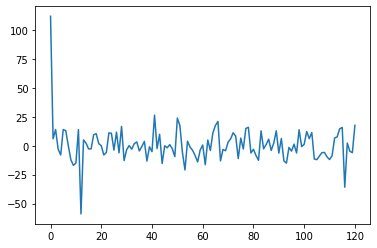

In [65]:
final_model.resid.plot()

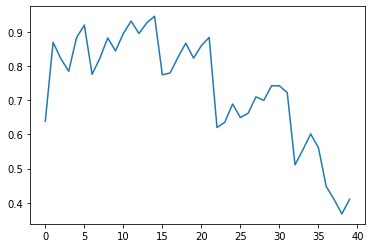

In [77]:
from statsmodels.stats.diagnostic import acorr_ljungbox

p_value = acorr_ljungbox(final_model.resid[1:])[1]
pd.Series(p_value).plot()

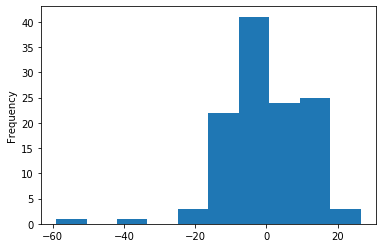

In [79]:
final_model.resid[1:].plot(kind='hist')

5. Forecast

In [80]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMA Predictions')

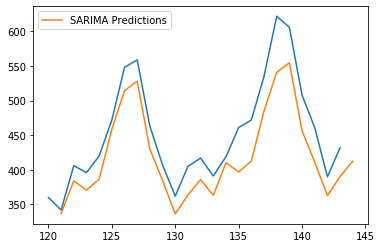

In [81]:
test.plot()
predictions.plot(legend=True)